In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0, '../')
import pandas as pd
import tqdm
import pickle

import vis
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
### Configure file and folder names
data_h5 = "../data/paper/soccermix_all_data.h5"
models = "../data/paper/soccermix_models.pkl"

d_weights = "../data/paper/soccermix_all_dirweights.pkl"

spadl_h5 = "../data/tomd/spadl-statsbomb.h5"

In [3]:
X = pd.read_hdf(data_h5, "X")

In [4]:
def loadall(filename):
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

items = loadall(models)
d_w = loadall(d_weights)

In [5]:
cat_model = next(items)
loc_models = next(items)
dir_models = next(items)

In [6]:
dir_weights = next(d_w)

In [7]:
teams = pd.read_hdf(spadl_h5, "teams")

In [8]:
games = pd.read_hdf(spadl_h5, "games")

In [9]:
games1819 = games[((games.competition_name == "Premier League") & 
                   (games.season_name == "2018/2019"))]

In [10]:
merged_weights = dir_weights.copy()
merged_weights["team_id"] = X.team_id.values
merged_weights["game_id"] = X.game_id.values

In [11]:
merged_weights = merged_weights[merged_weights.game_id.isin(games1819.game_id)]

In [12]:
# inefficient --> slow

vectors = {}
set_teams = set(merged_weights.team_id.astype('int'))

for p in tqdm.tqdm(list(merged_weights.team_id.unique())):
    other_teams = set_teams - {int(p)}
    for p2 in other_teams:
        remaining_teams = other_teams - {p2}
        
        A_B_games = games1819[((( (games1819.away_team_id == p) & (games1819.home_team_id == p2)) 
                          |( (games1819.away_team_id == p2) & (games1819.home_team_id == p)))
                          )].game_id.values
                
        B_other_games = games1819[((( (games1819.away_team_id == p2) & (games1819.home_team_id.isin(remaining_teams)) )
                              | ((games1819.away_team_id.isin(remaining_teams)) & (games1819.home_team_id == p2)))
                              )].game_id.values
        
        
        vec1 = merged_weights.loc[((merged_weights.game_id.isin(A_B_games)) 
                                  & (merged_weights.team_id == p2)), dir_weights.columns].sum().values
        vec1 /= 2
            
        
        vec2 = merged_weights.loc[((merged_weights.game_id.isin(B_other_games))
                                  & (merged_weights.team_id == p2)), dir_weights.columns].sum().values
        vec2 /= 36
        
        vectors[f'{int(p)}_{int(p2)}_0'] = vec1 #vector of team 2 when playing only against team 1
        vectors[f'{int(p)}_{int(p2)}_1'] = vec2 #vector of team 2 when playing against all other teams except team 1

100%|██████████| 20/20 [05:02<00:00, 15.13s/it]


In [13]:
vectors_pd = pd.concat({k: pd.DataFrame(v).T for k,v in vectors.items()}).droplevel(level=1)
vectors_pd.index.name = "team_game"
vectors_pd.columns = dir_weights.columns

In [14]:
def show_vectors(team_id, set_teams, teams, vectors_pd):
    other_teams = set_teams - {int(team_id)}
    for p2 in other_teams:
        print(teams[teams.team_id == team_id].team_name.values[0] + "-" + teams[teams.team_id == p2].team_name.values[0])
        sli = vectors_pd.loc[vectors_pd.index.str.contains(f'^{int(team_id)}_{int(p2)}_')]
        plt.figure(figsize=(50,10))
        plt.plot(vectors_pd.columns.values, sli.iloc[0,:].values, 'r') 
        plt.plot(vectors_pd.columns.values, sli.iloc[1,:].values, 'b')
        plt.show()

In [15]:
def get_mean_difference_vector(team):
    differences = []
    for t in set_teams:
        if (t != team):
            differences.append(vectors_pd.loc[f"{team}_{int(t)}_0"] - vectors_pd.loc[f"{team}_{int(t)}_1"])
            # difference between how team t plays against 'team' and how team t play against all other teams
            
    mean_vector = np.mean(differences, 0)
    mean_pd = pd.DataFrame(columns=vectors_pd.columns.values)
    mean_pd.loc[0] = mean_vector
    mean_pd.loc[1] = np.zeros_like(mean_vector)
    
    return mean_pd

# Defensive style of Liverpool

In [20]:
print(teams[teams.team_name == 'Liverpool'].team_id)

18    24
Name: team_id, dtype: int64


Liverpool-Arsenal


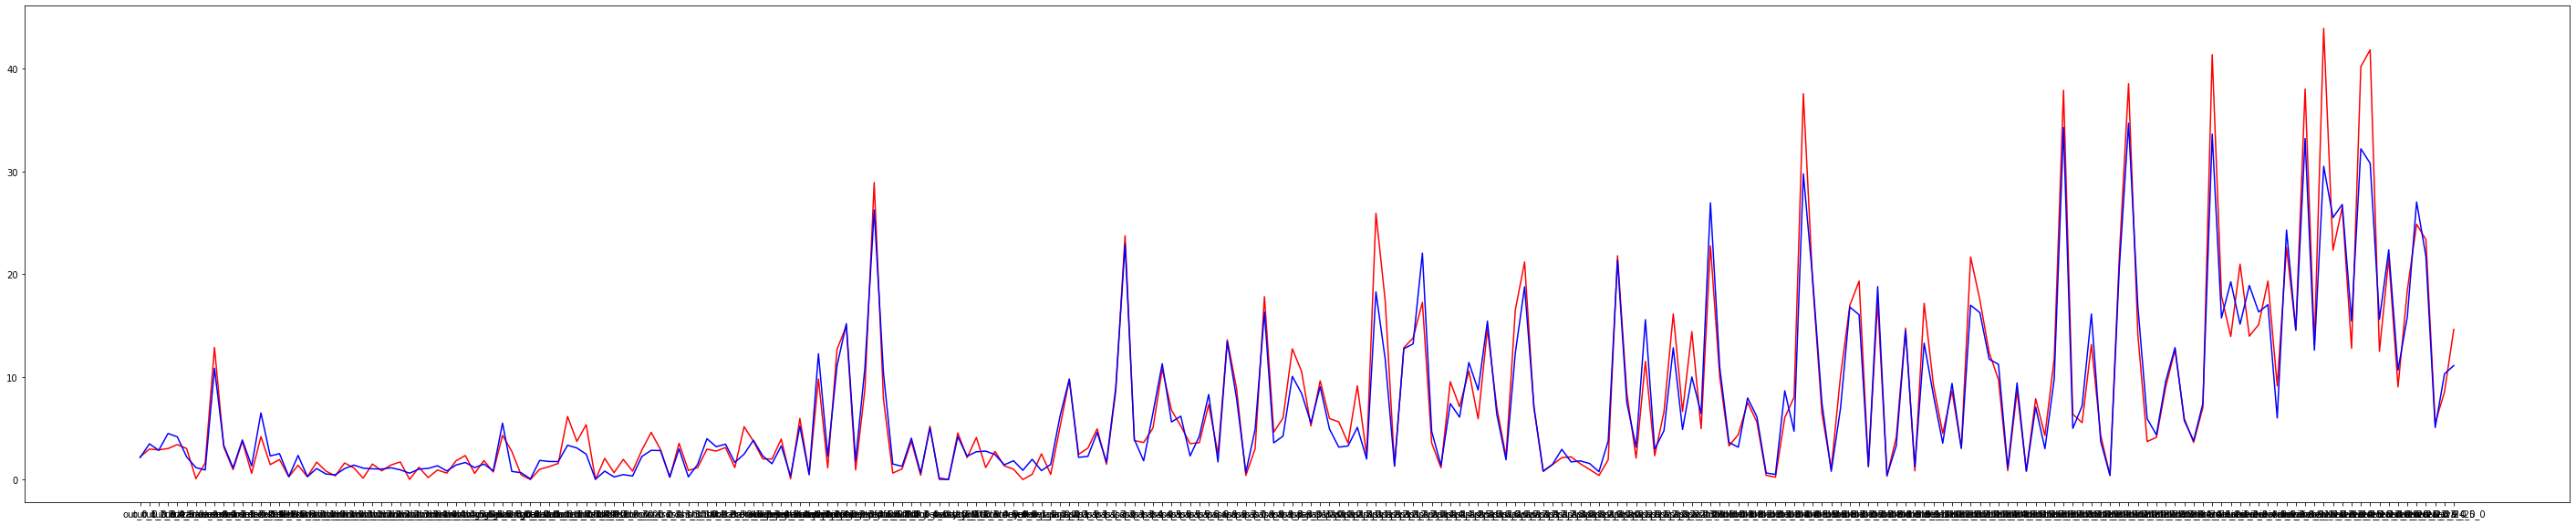

Liverpool-Leicester City


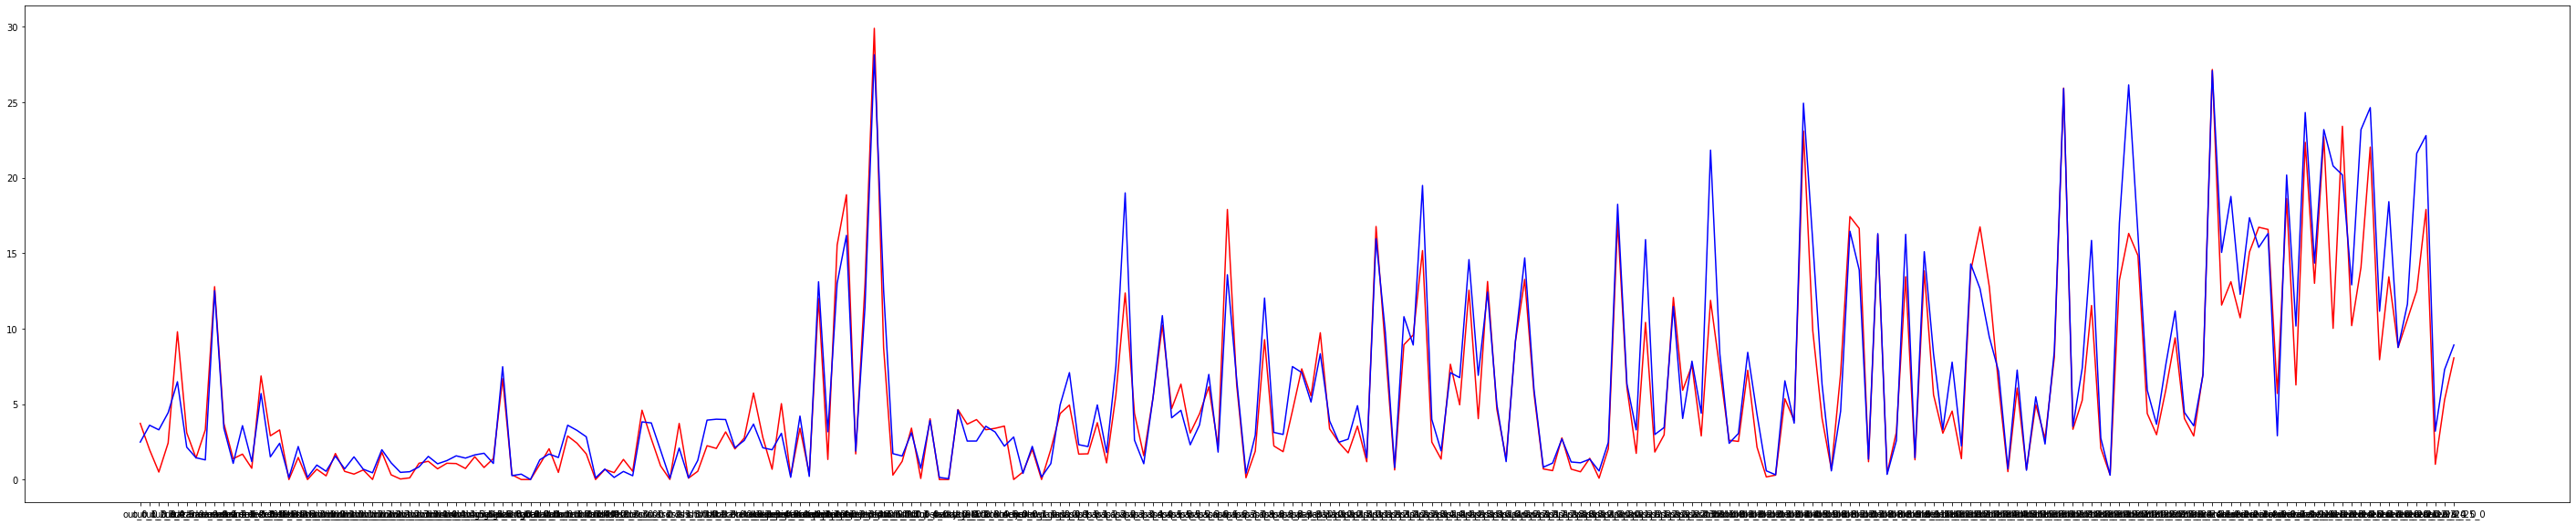

Liverpool-Watford


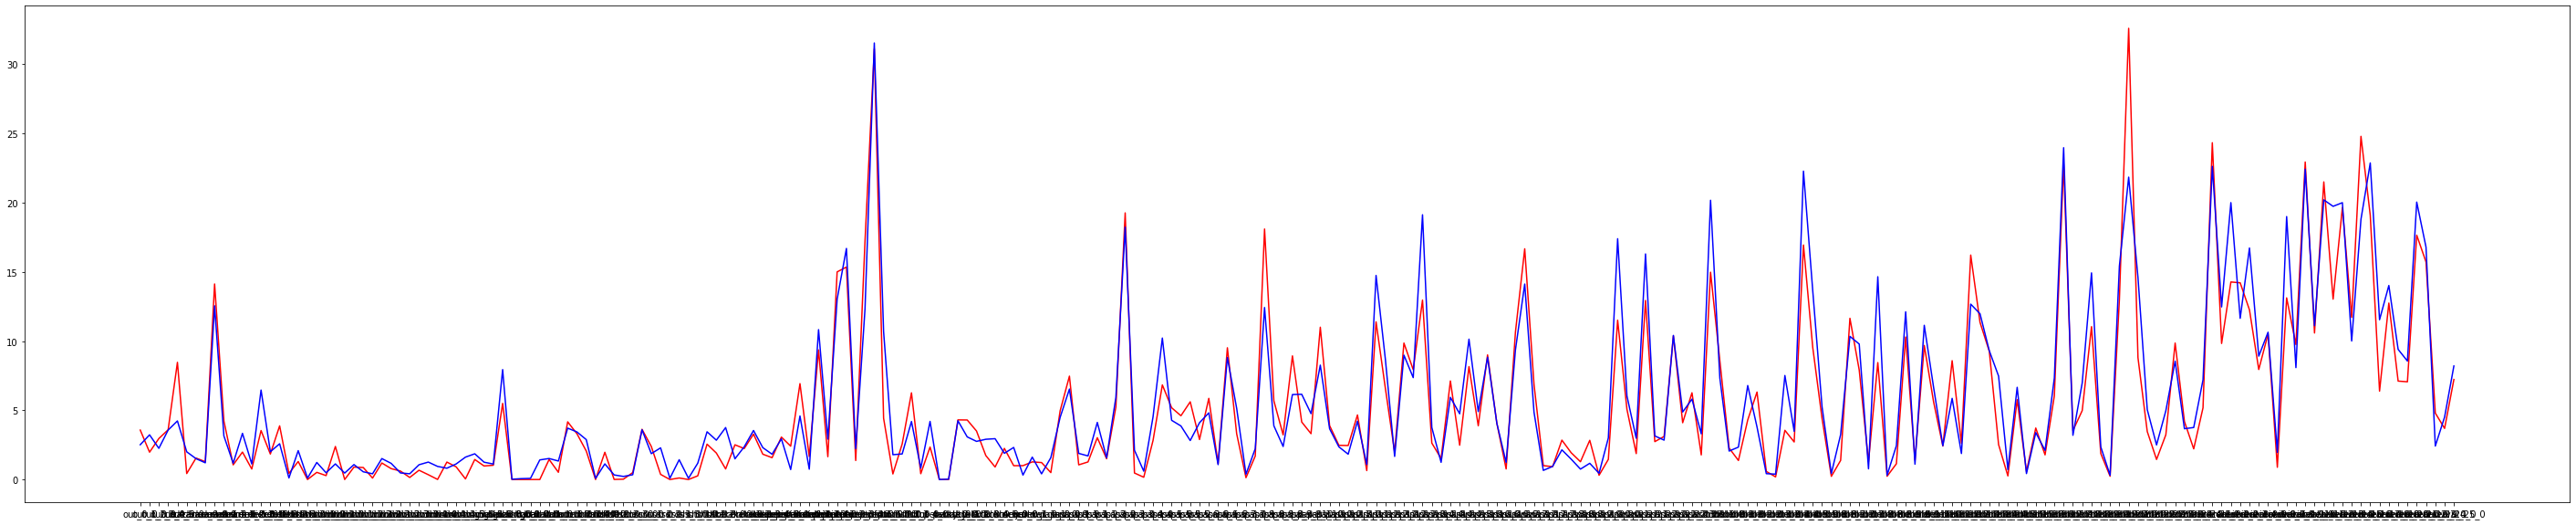

Liverpool-Southampton


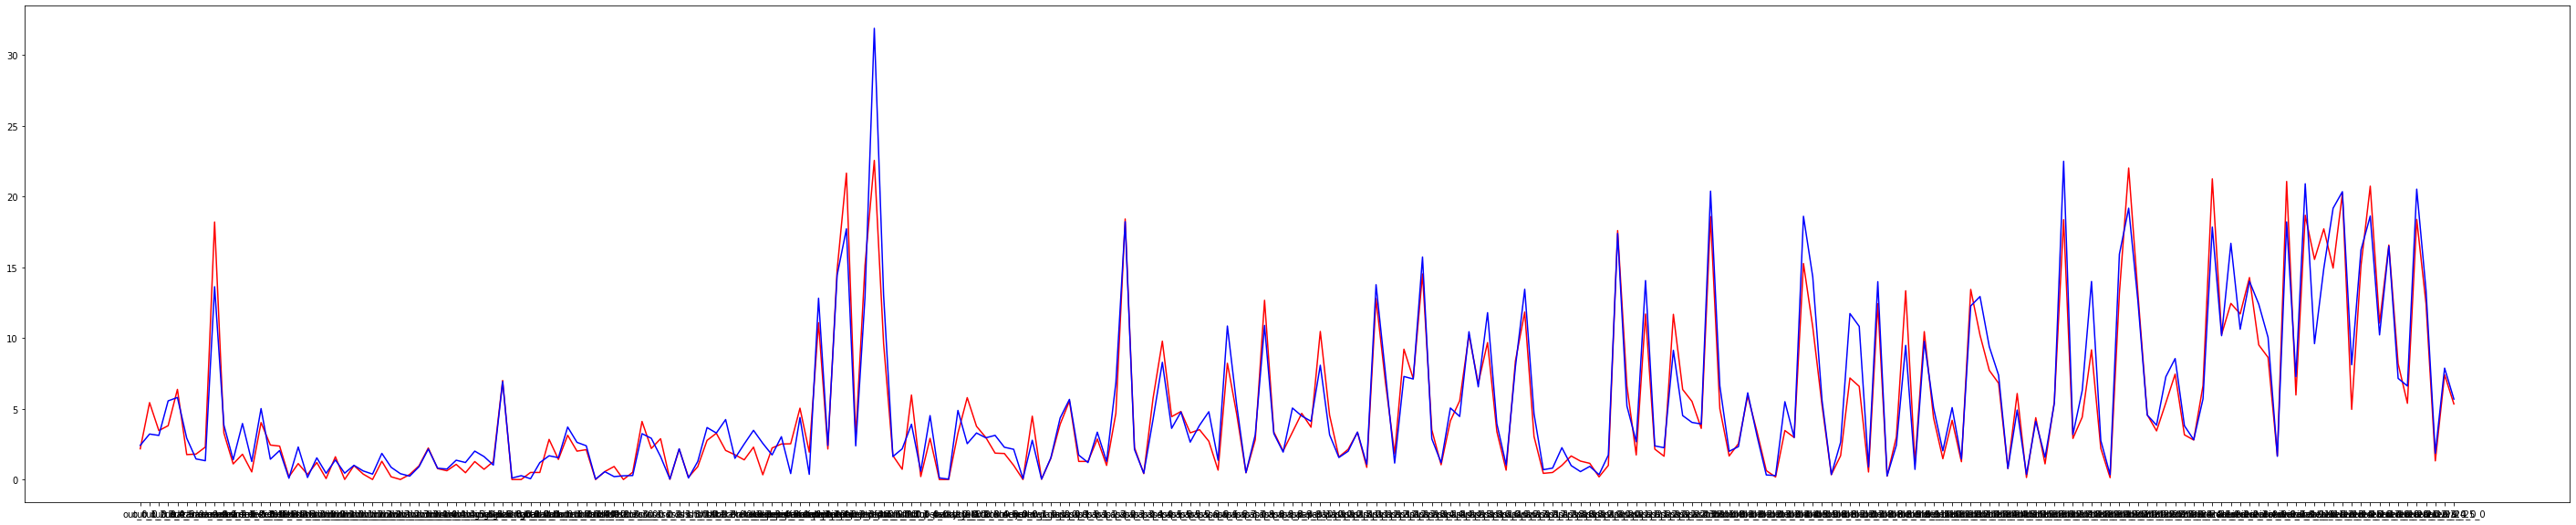

Liverpool-AFC Bournemouth


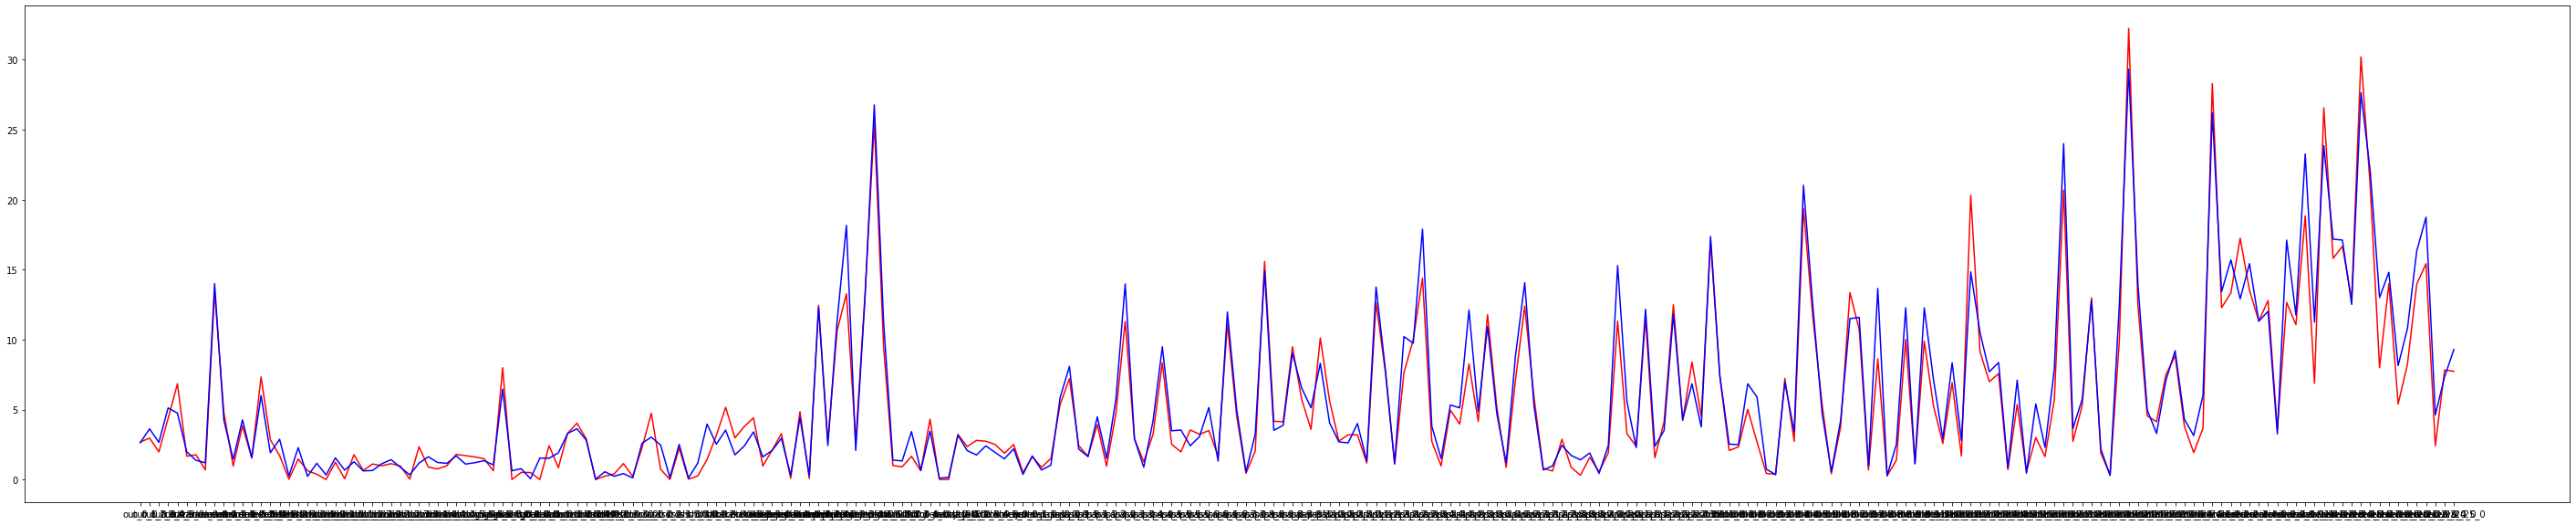

Liverpool-Everton


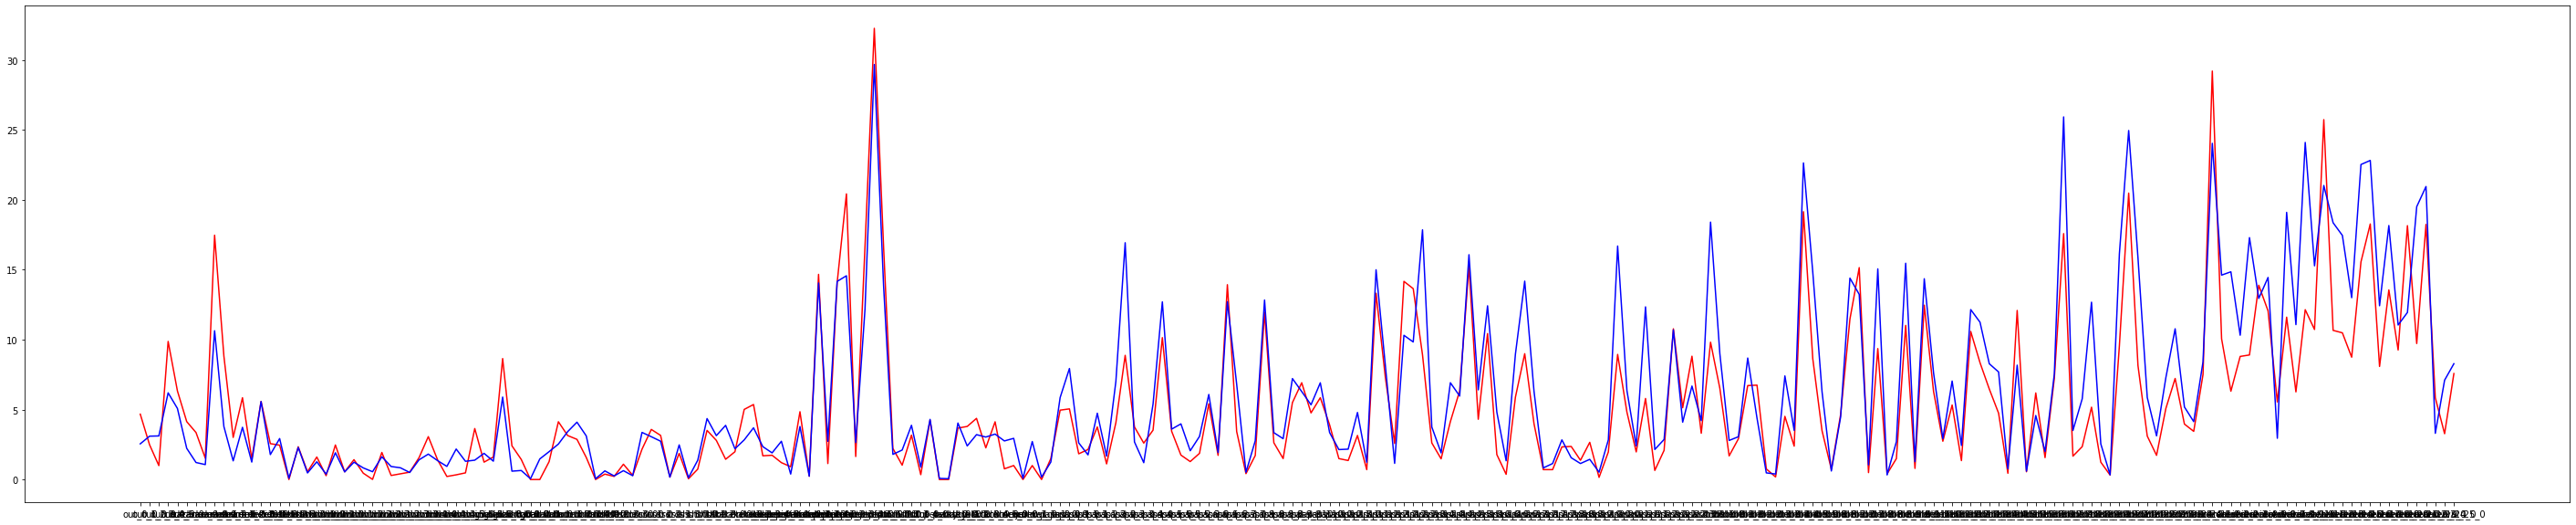

Liverpool-Crystal Palace


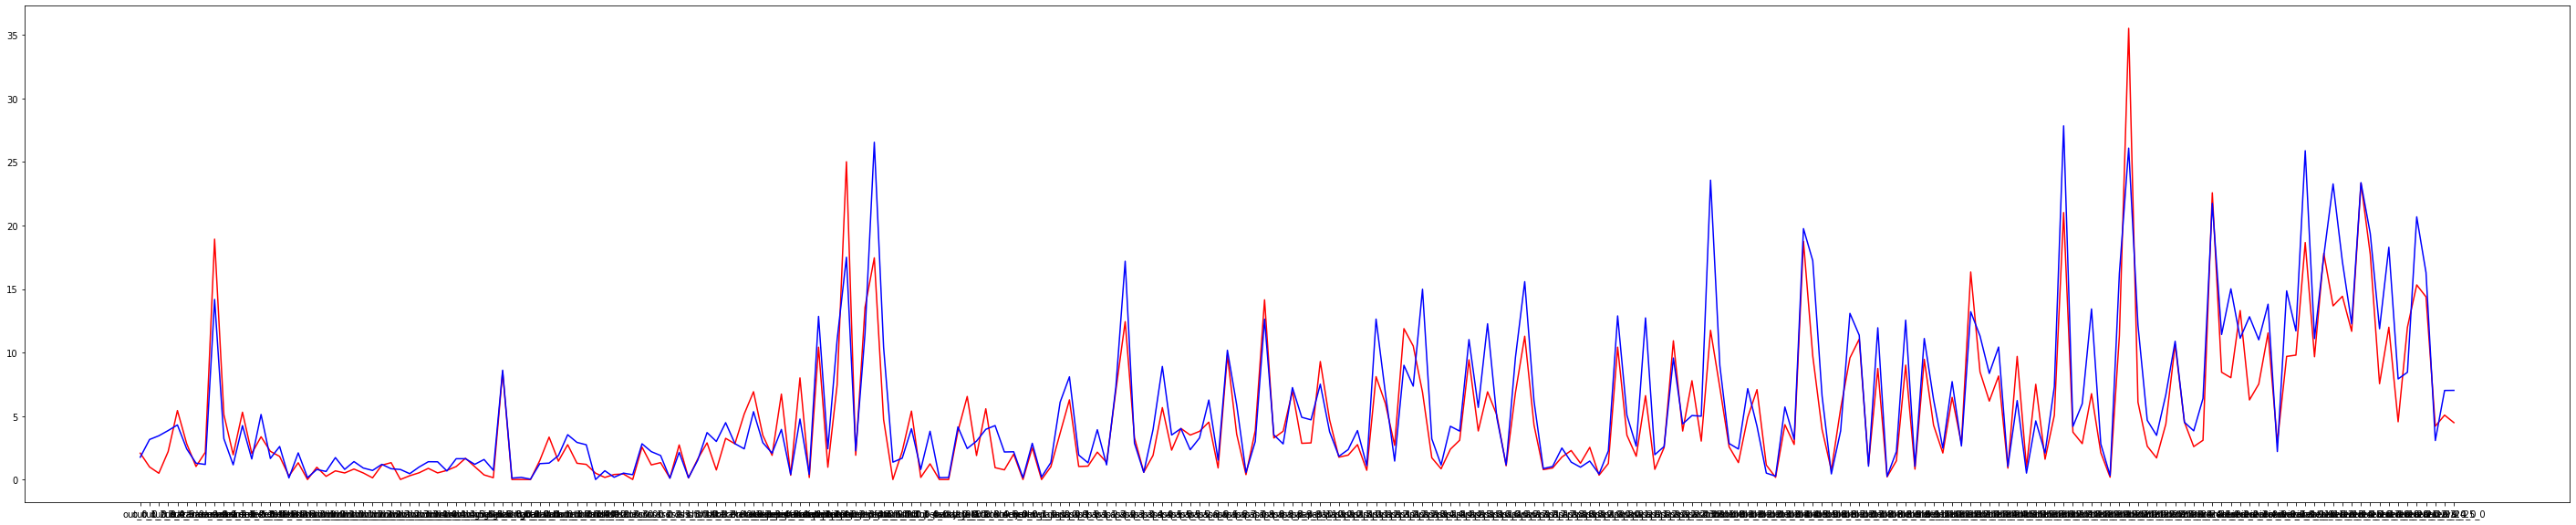

Liverpool-Huddersfield Town


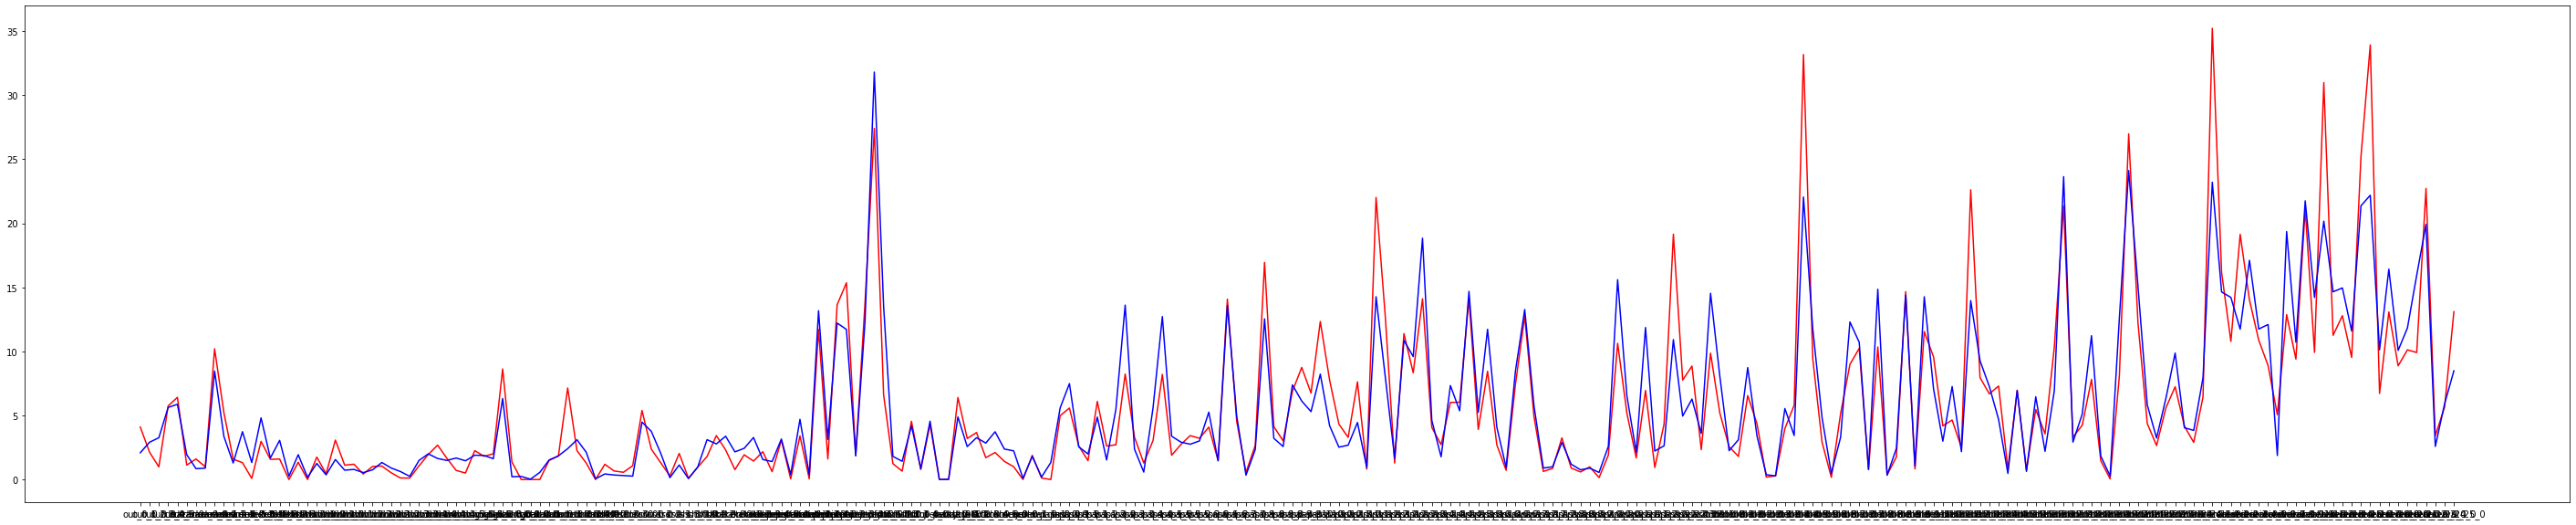

Liverpool-Chelsea


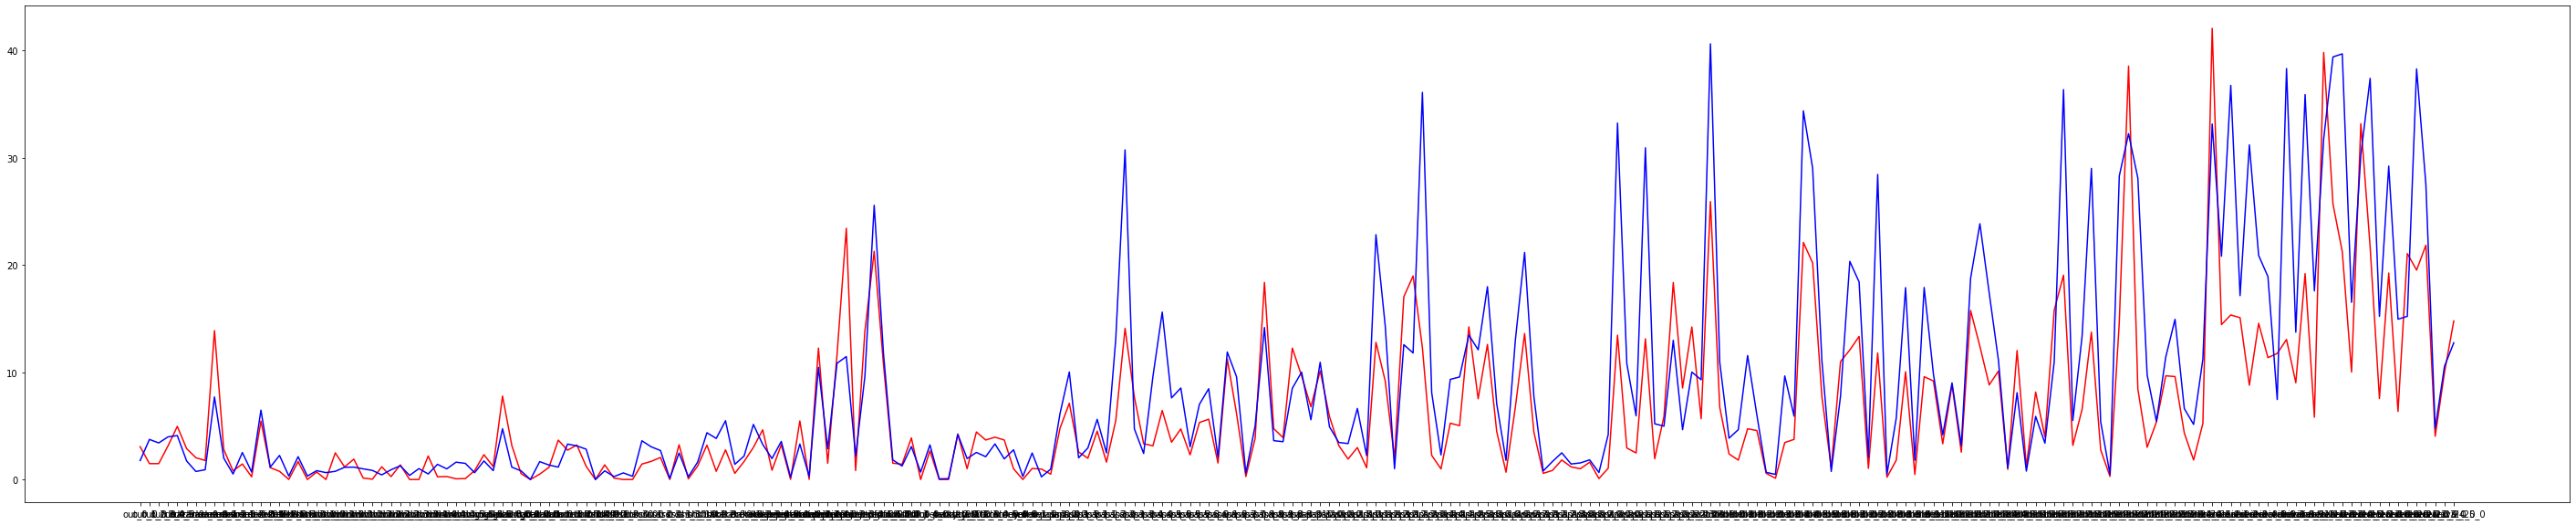

Liverpool-Burnley


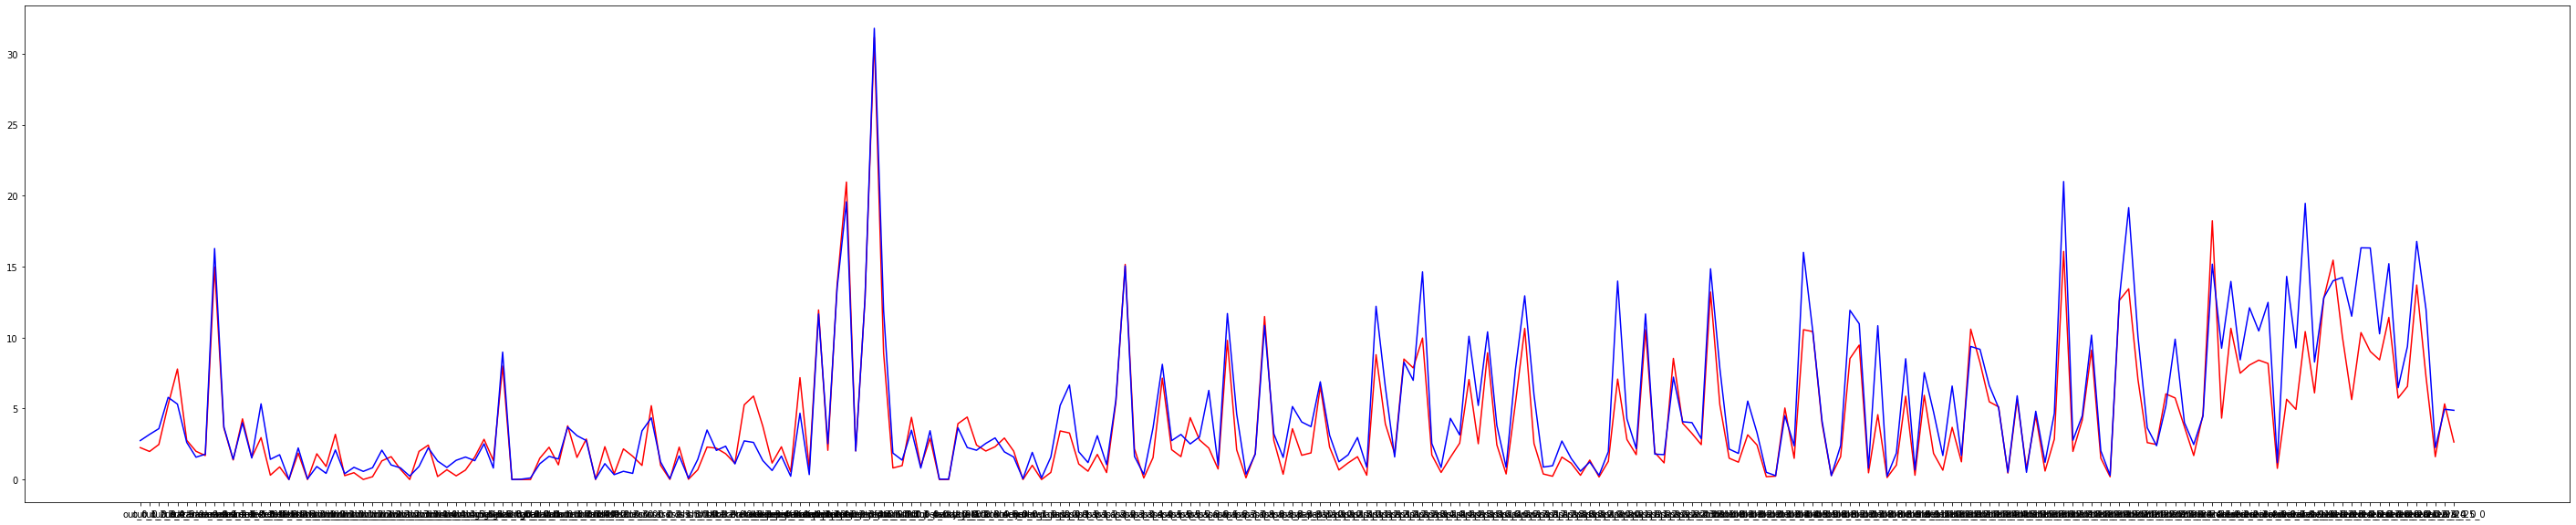

Liverpool-Brighton & Hove Albion


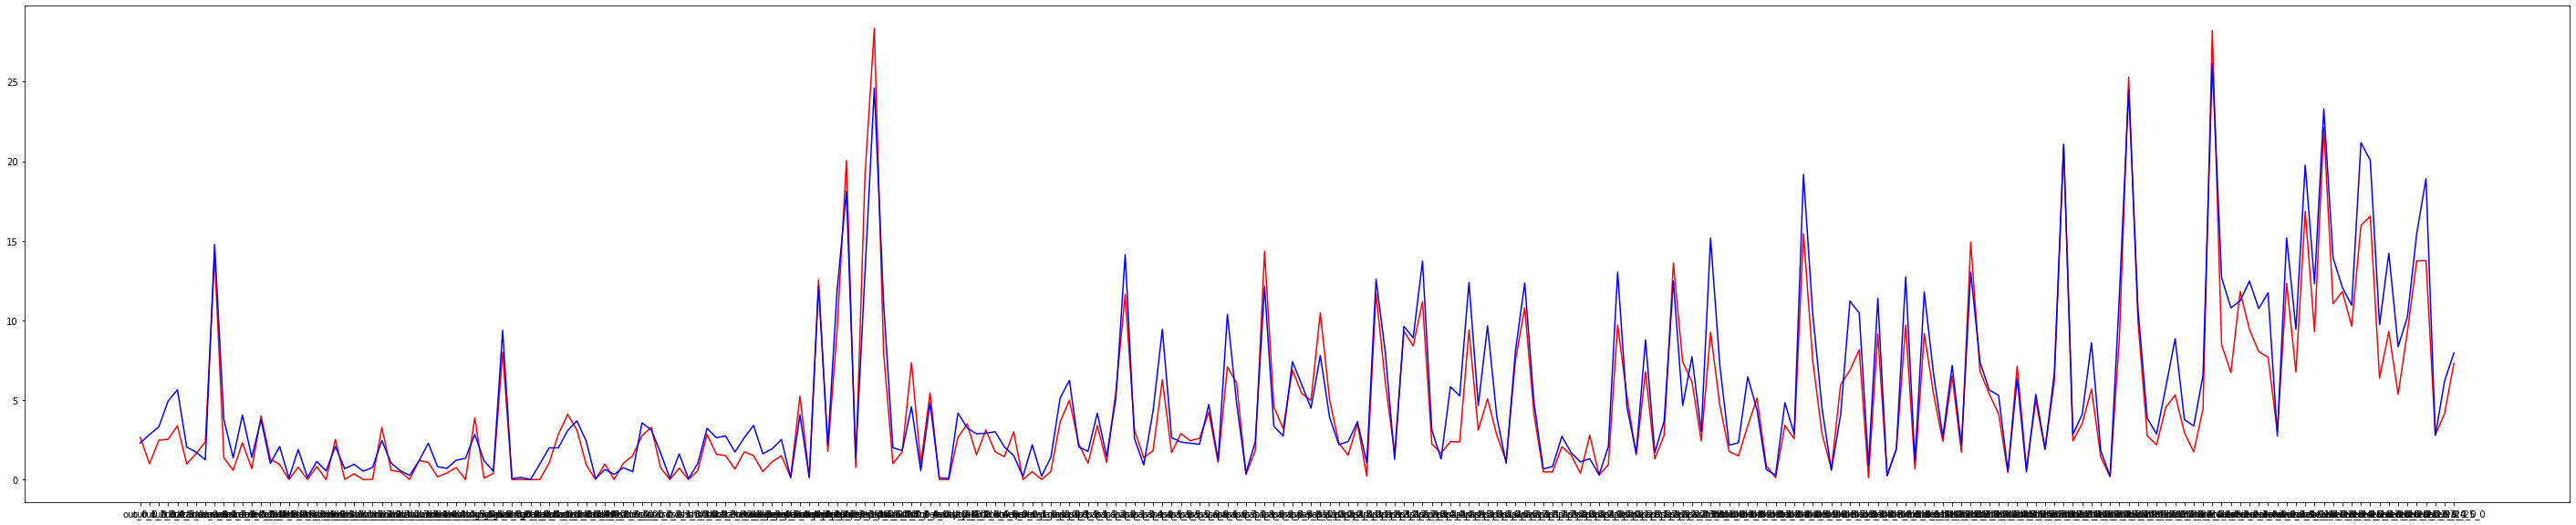

Liverpool-Manchester City


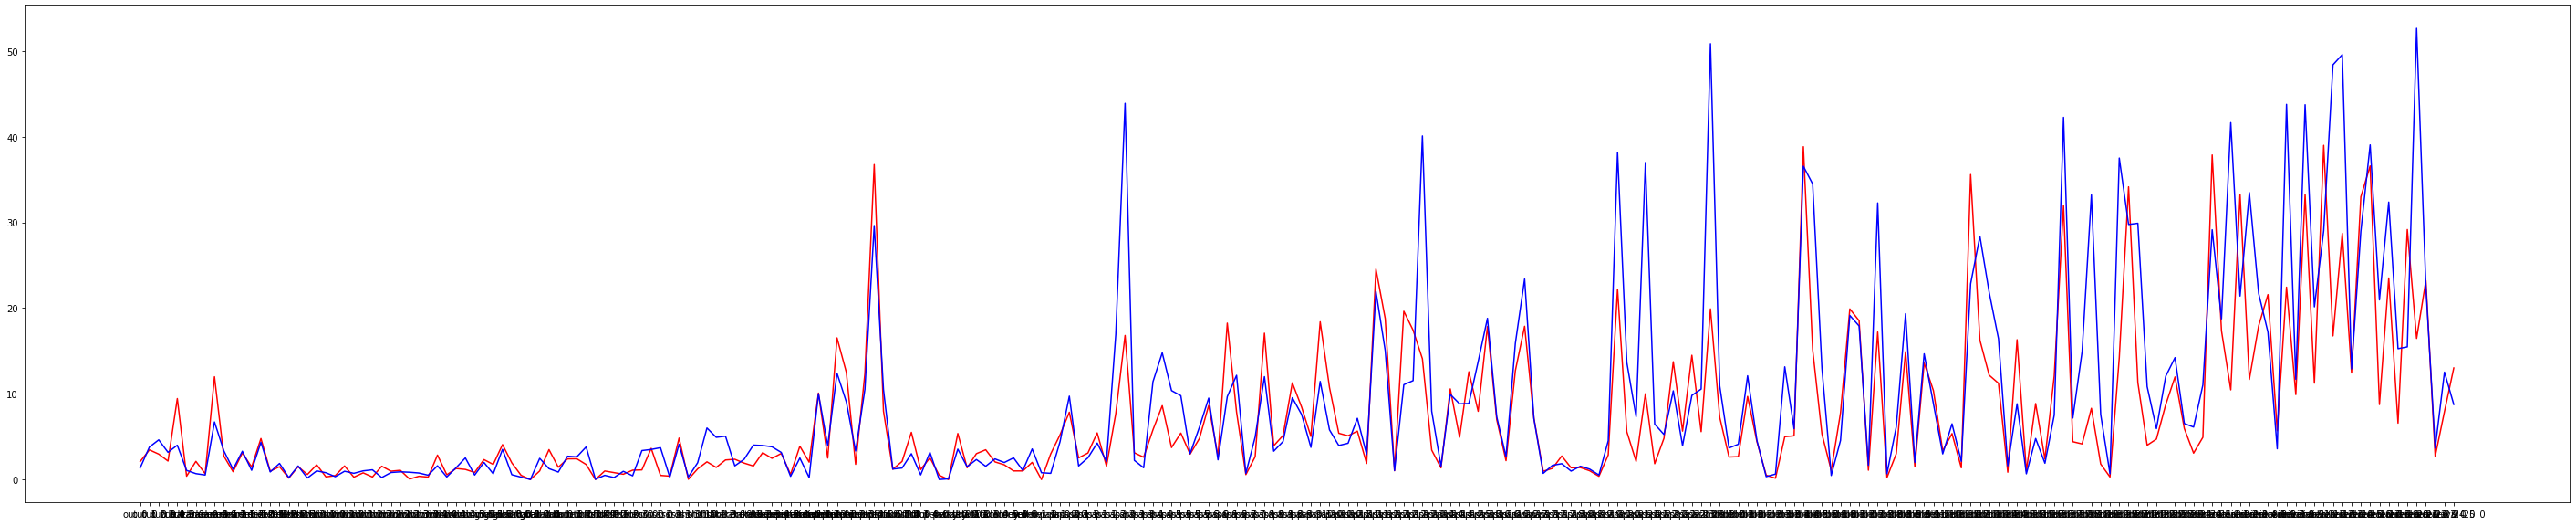

Liverpool-Newcastle United


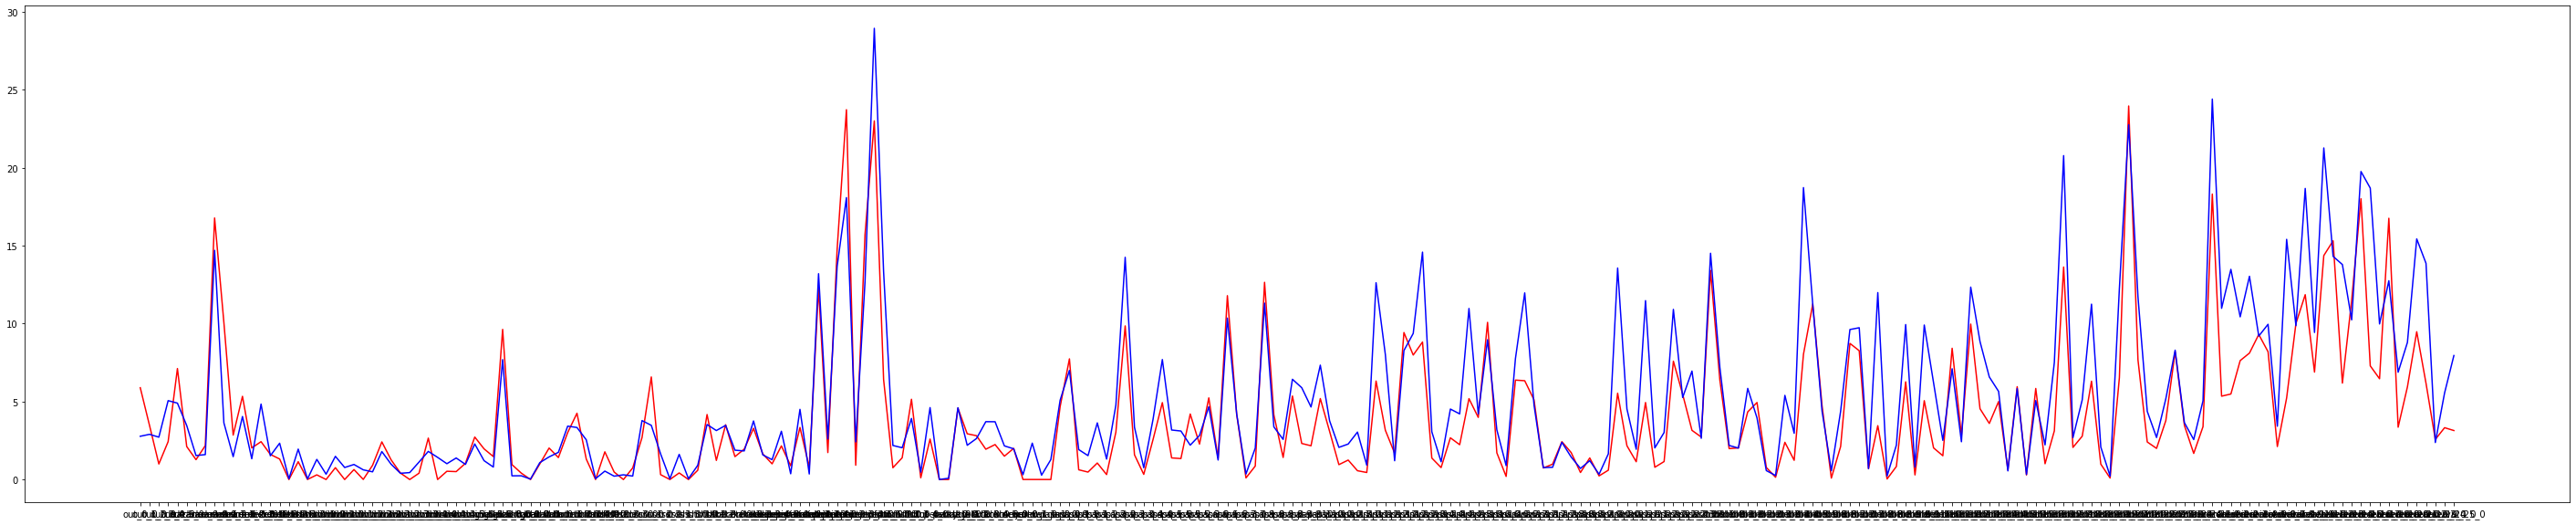

Liverpool-Tottenham Hotspur


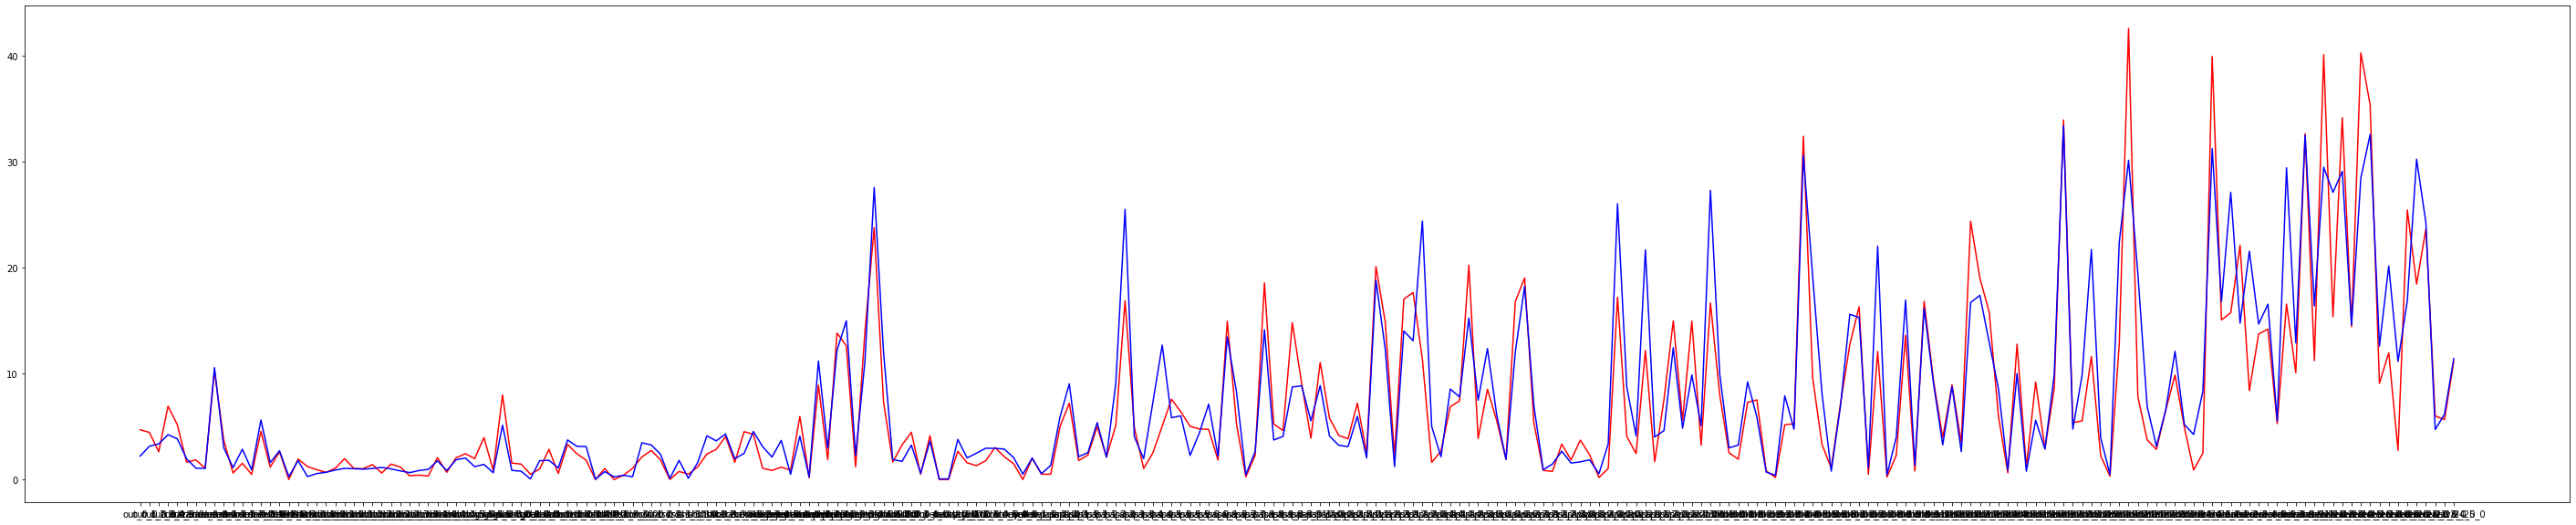

Liverpool-Manchester United


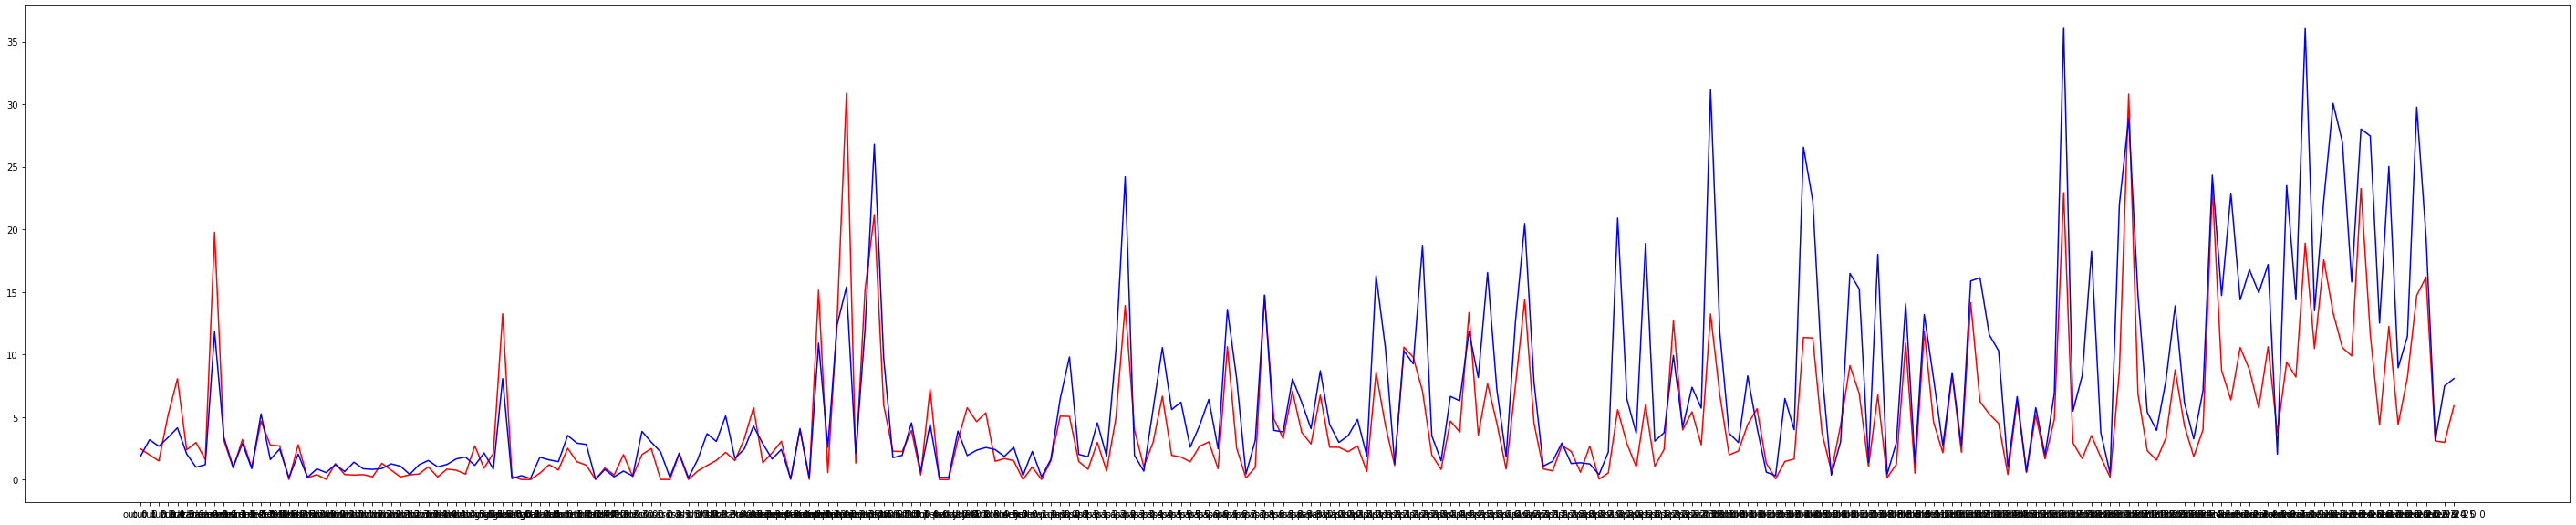

Liverpool-West Ham United


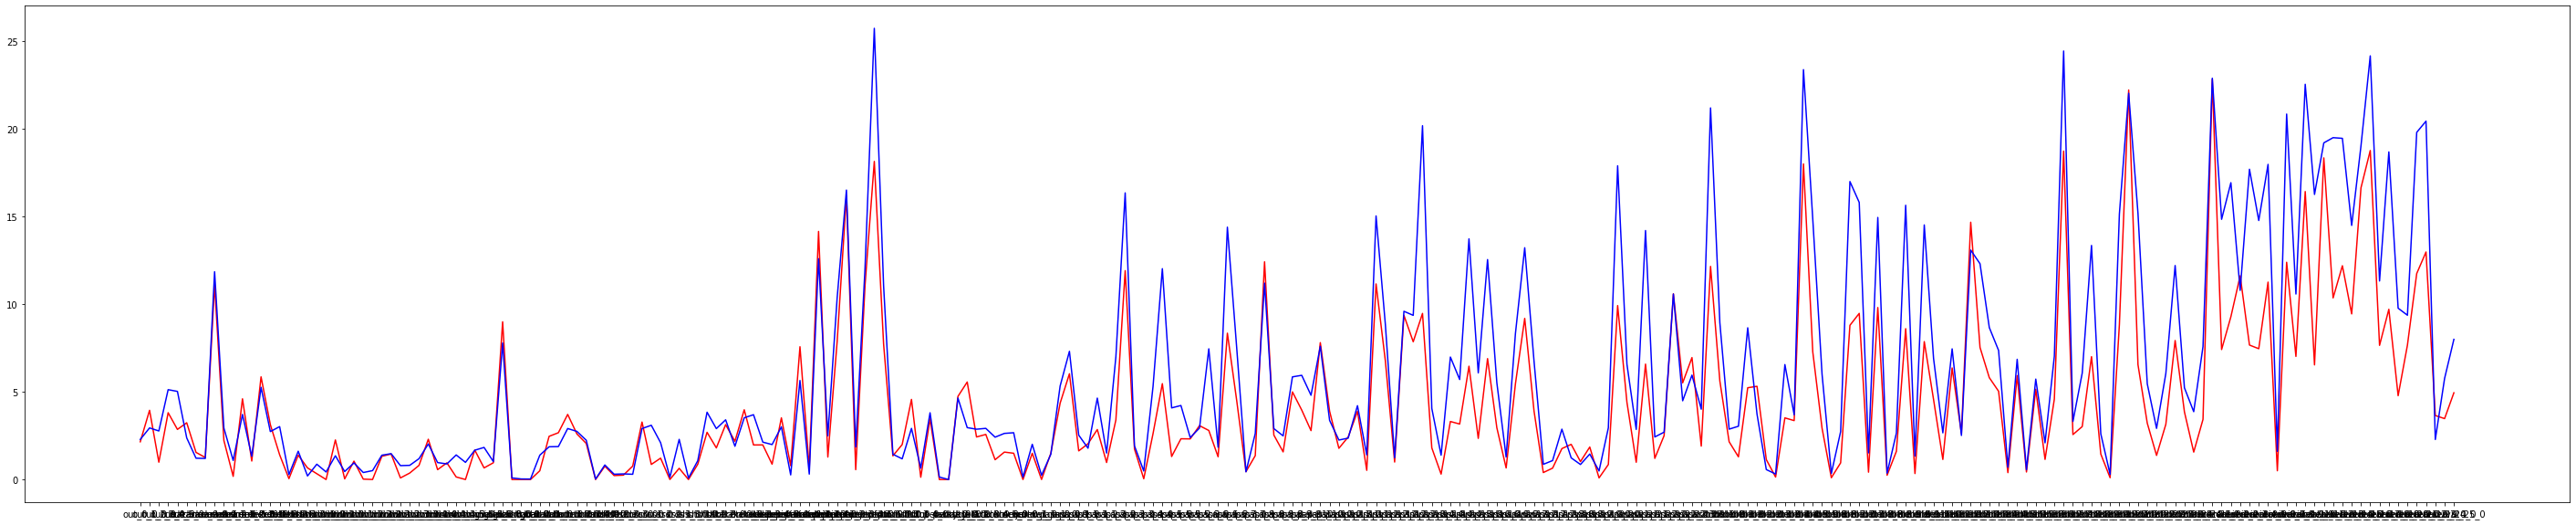

Liverpool-Wolverhampton Wanderers


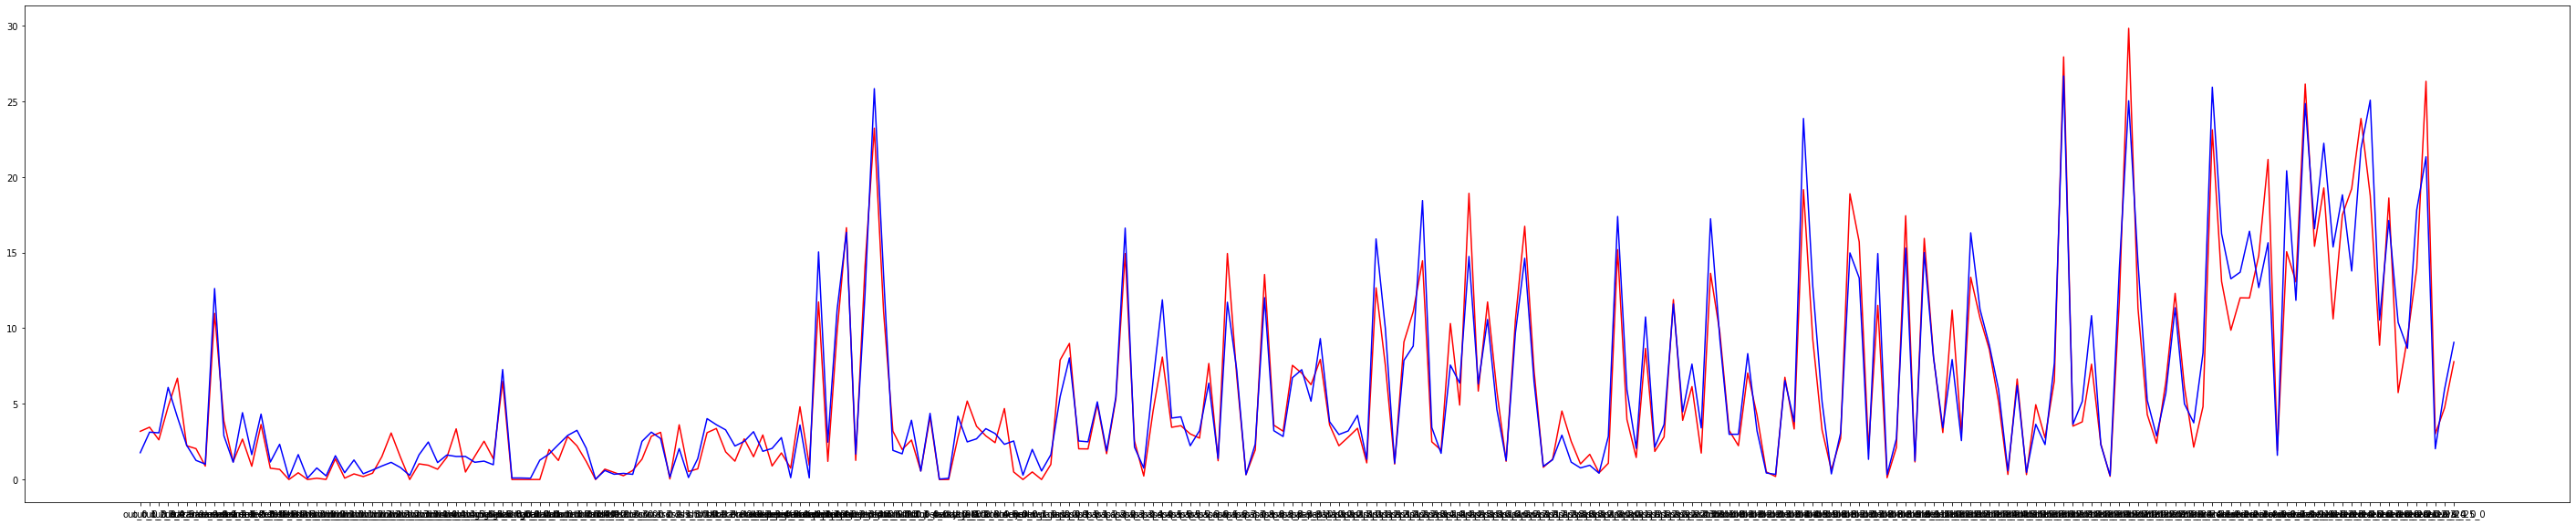

Liverpool-Fulham


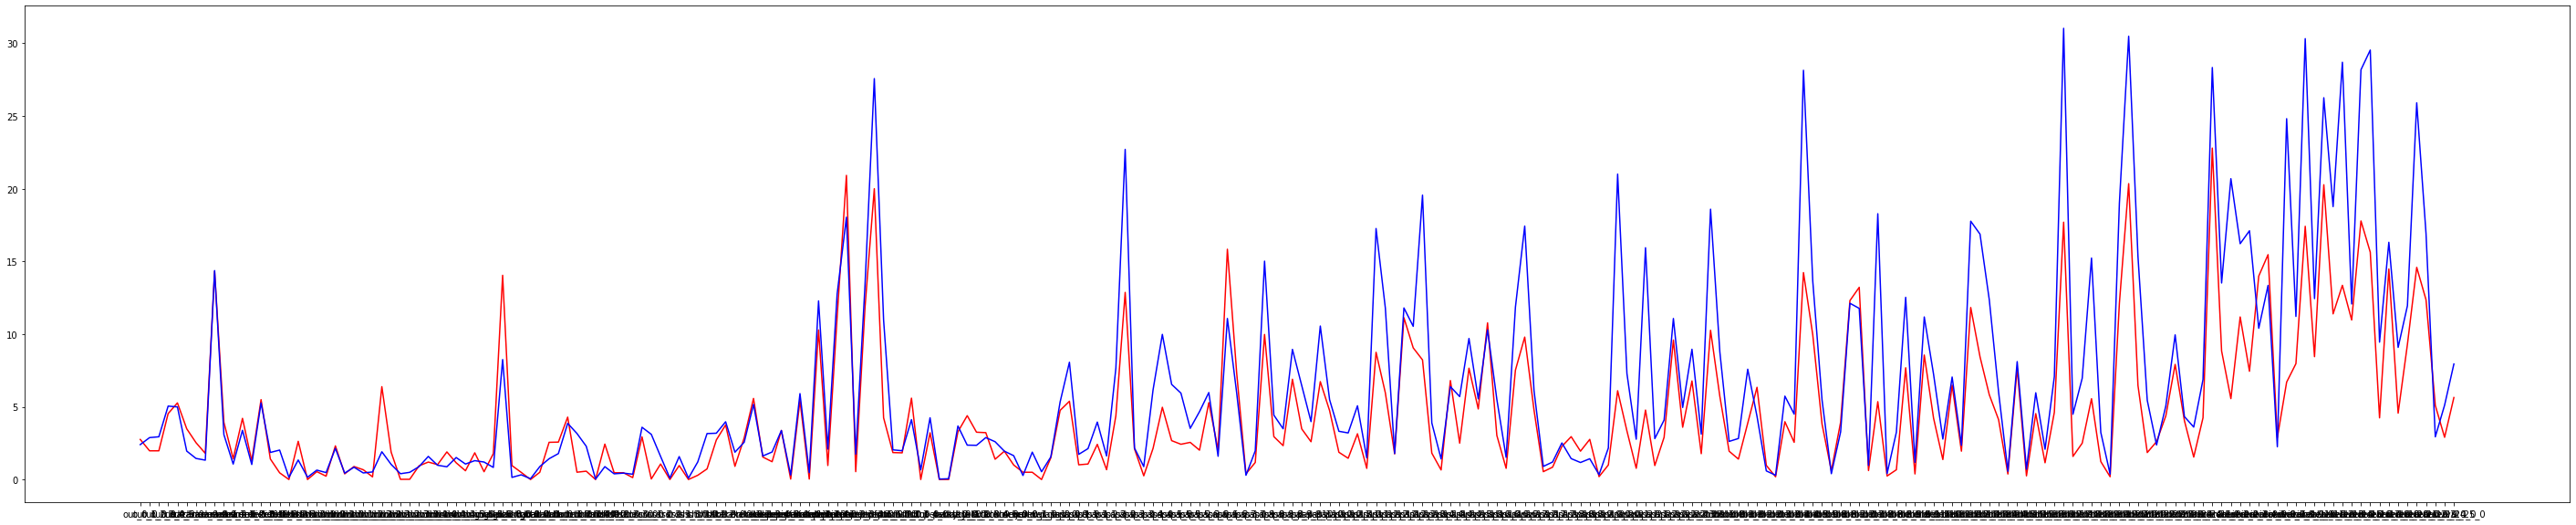

Liverpool-Cardiff City


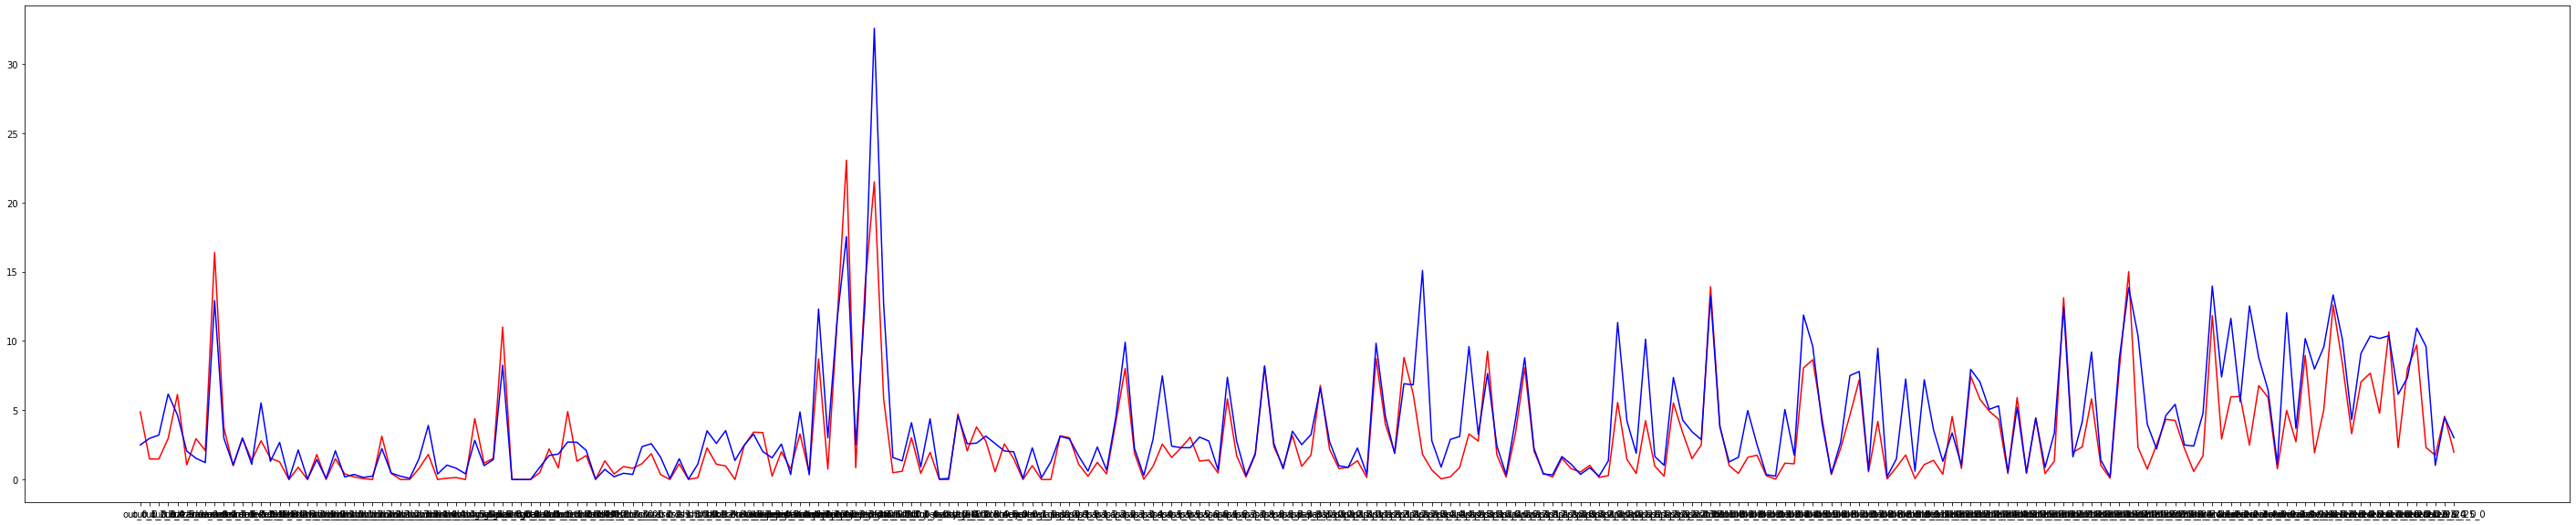

In [16]:
show_vectors(24, set_teams, teams, vectors_pd)

In [17]:
mean_pd_24 = get_mean_difference_vector(24)

out 6


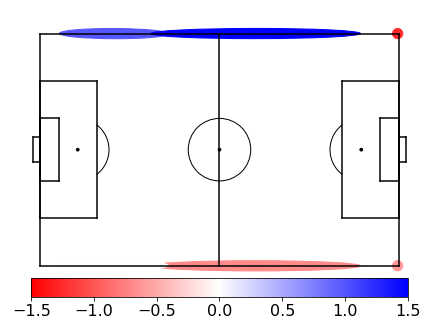

clearance 3
clearance_0 3
clearance_1 2
clearance_2 2


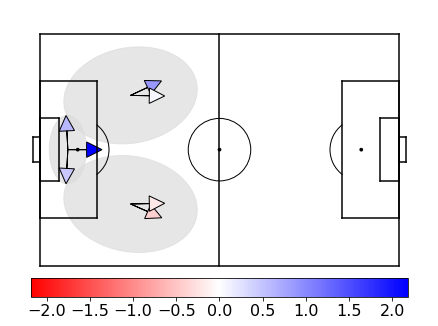

freekick 4
freekick_0 1
freekick_1 1
freekick_2 2
freekick_3 2


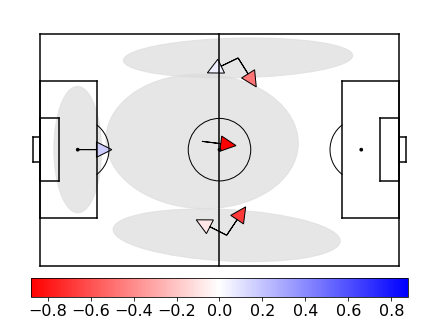

throw_in 6
throw_in_0 2
throw_in_1 4
throw_in_2 4
throw_in_3 2
throw_in_4 4
throw_in_5 4


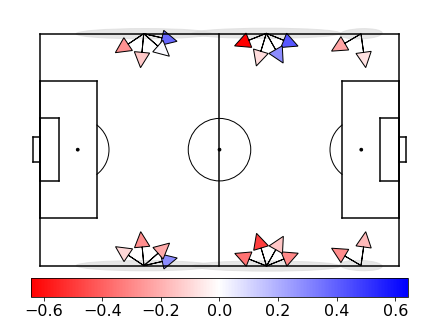

goalkick 1
goalkick_0 3


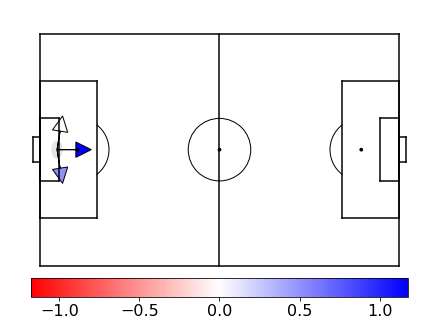

owngoal 1


../vis.py:179: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


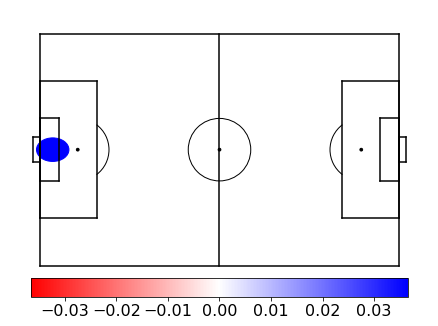

goal 1


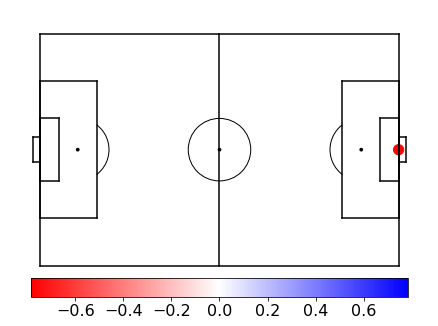

bad_touch 5


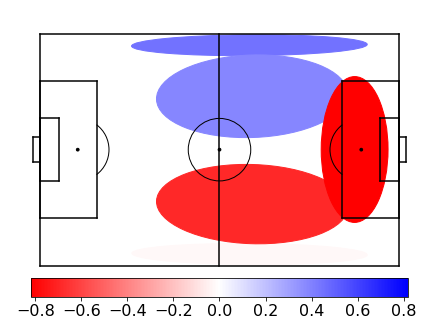

red_card 1


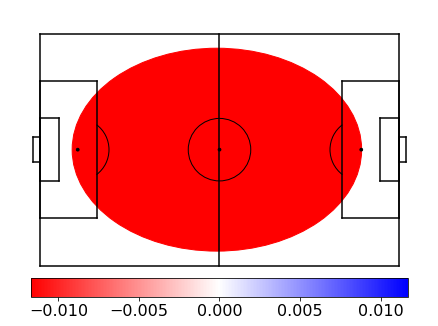

offside 4


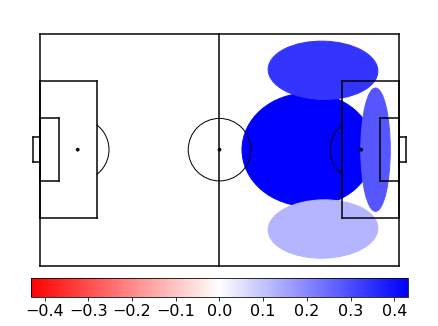

cross 4
cross_0 1
cross_1 1
cross_2 2
cross_3 2


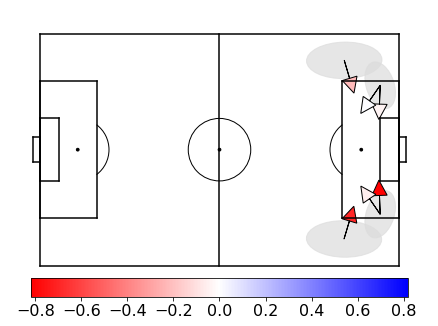

shot 3
shot_0 2
shot_1 1
shot_2 1


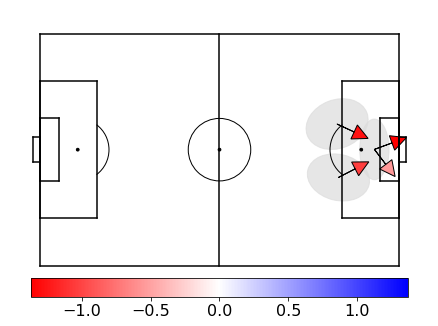

take_on 6


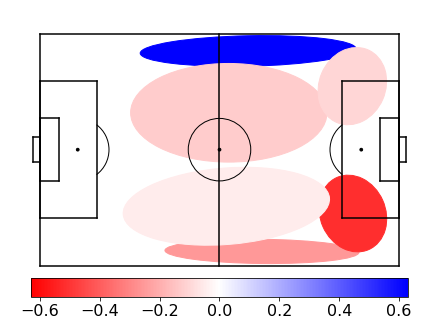

keeper_catch 3


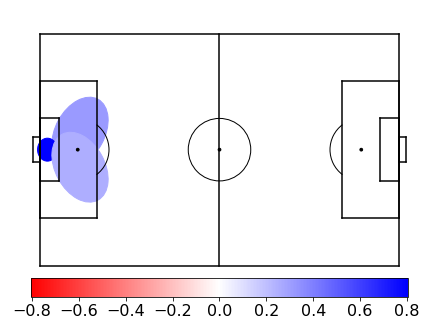

interception 8


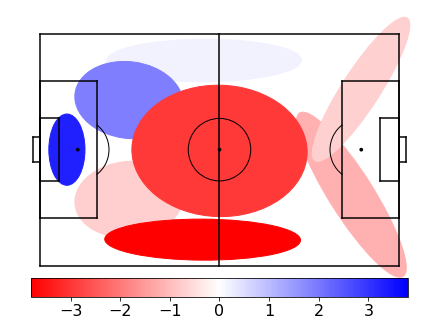

foul 5


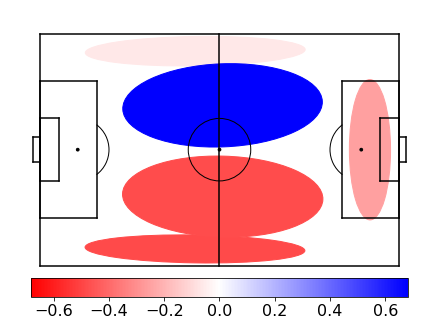

shot_penalty 1
shot_penalty_0 2


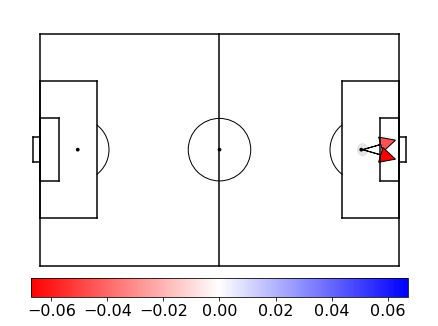

tackle 6


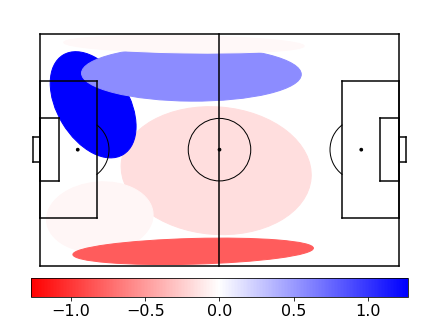

corner 2
corner_0 2
corner_1 2


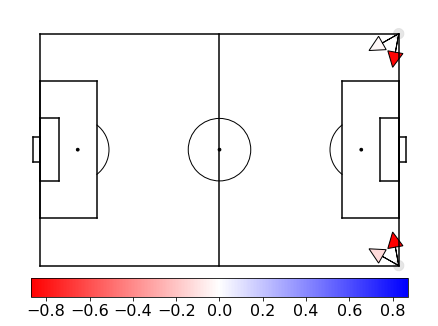

yellow_card 1


../vis.py:179: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


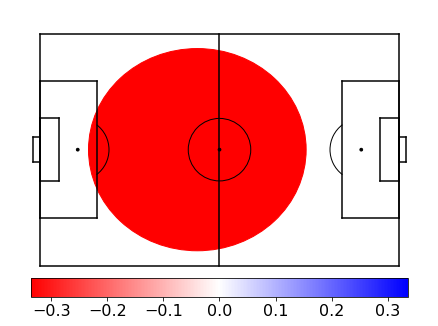

pass 24
pass_0 2
pass_1 4
pass_2 2
pass_3 2
pass_4 2
pass_5 4
pass_6 4
pass_7 2
pass_8 4
pass_9 2
pass_10 4
pass_11 4
pass_12 3
pass_13 2
pass_14 4
pass_15 2
pass_16 4
pass_17 4
pass_18 3
pass_19 2
pass_20 2
pass_21 3
pass_22 4
pass_23 2


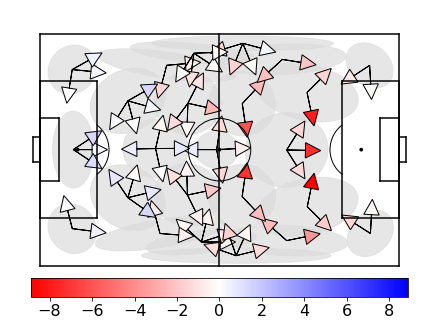

dribble 26
dribble_0 2
dribble_1 2
dribble_2 2
dribble_3 2
dribble_4 2
dribble_5 2
dribble_6 2
dribble_7 3
dribble_8 3
dribble_9 3
dribble_10 2
dribble_11 2
dribble_12 1
dribble_13 2
dribble_14 2
dribble_15 3
dribble_16 2
dribble_17 2
dribble_18 2
dribble_19 3
dribble_20 1
dribble_21 2
dribble_22 2
dribble_23 2
dribble_24 2
dribble_25 1


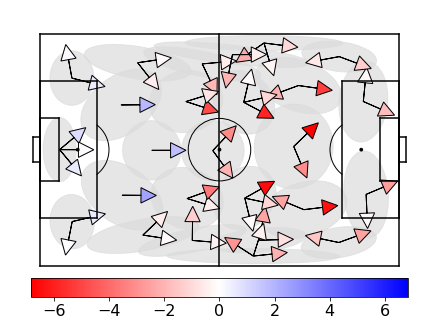

receival 26


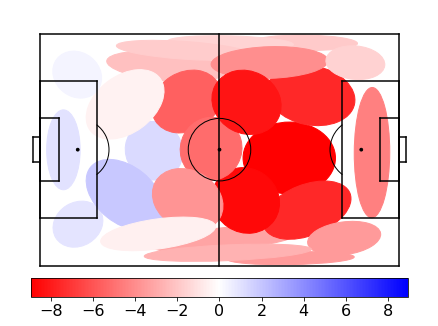

In [19]:
vis.show_component_differences(loc_models, dir_models, mean_pd_24.loc[0], mean_pd_24.loc[1], 'Liverpool', 'all', save=False)